In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from tqdm.auto import tqdm
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/6004/project 2/code'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Settings



In [ ]:
class icuDataset(Dataset):
  def __init__(self, x, y):
    super(icuDataset, self).__init__()
    # store the raw tensors
    self._x = x
    self._y = y

  def __len__(self):
    # size of Dataset
    return self._x.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    x = self._x[idx, :]
    y = self._y[idx]
    return x, y

In [ ]:
def save_checkpoints(encoder, decoder, opt, checkpoint_path):
    save_dict = {}
    save_dict.update({'encoder': encoder.state_dict()})
    save_dict.update({'decoder': decoder.state_dict()})
    save_dict.update({'opt': opt.state_dict()})
    torch.save(save_dict, checkpoint_path)

def load_checkpoints(encoder, decoder, opt, checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    encoder.load_state_dict(ckpt['encoder'])
    decoder.load_state_dict(ckpt['decoder'])
    opt.load_state_dict(ckpt['opt'])

In [ ]:
def cal_accuracy(y_pred, y_true):
    y_pred_rounded = torch.round(y_pred)
    correct = (y_pred_rounded == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [ ]:
# parameters

# datasets after preprocessing
file_path = '/content/drive/My Drive/6004/project2/code/clean_regres.csv'
data_2 = pd.read_csv(file_path)

# pre-defined global parameters
seed = 123
learning_rate = 0.001
num_epochs = 200
device = "cuda" if torch.cuda.is_available() else "cpu"

log_dir = 'models/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# set seeds
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


## ICU duration (continuous) without death/discharge classification

In [ ]:
y0 = torch.tensor(data_2['los_icu'], dtype = torch.float32)
X0 = torch.tensor(data_2.iloc[:, 3:].values, dtype = torch.float32)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.2, random_state = seed)

train_data_0 = icuDataset(X0_train, y0_train)
test_data_0 = icuDataset(X0_test, y0_test)

train_loader_0 = DataLoader(train_data_0, batch_size = 128, shuffle = True)
test_loader_0 = DataLoader(test_data_0, batch_size = 128, shuffle = False)

### Neural network (Linear encoder)

In [208]:
# baseline network
class BaseRegressor(nn.Module):
    def __init__(self):
        super(BaseRegressor, self).__init__()
        self.fc_b1 = nn.Linear(65, 32)
        self.fc_b2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc_b1(x))
        x = F.relu(self.fc_b2(x))
        return x

In [209]:
br = BaseRegressor().to(device)

# loss function
loss_func = torch.nn.MSELoss()

# optimizer
opt = optim.SGD(list(br.parameters()), lr = 0.0001, momentum = 0.9, weight_decay = 5e-4)

In [210]:
def regression_accuracy(output, target, threshold=0.1):
    """ Calculate "accuracy" for regression within a certain threshold percentage. """
    with torch.no_grad():
        # Calculate the absolute difference
        difference = torch.abs(output - target)
        # Check if the difference is within the threshold * target
        correct = (difference < threshold * torch.abs(target)).float()
        # Calculate accuracy as the mean of correct predictions
        accuracy = 100 * correct.mean()
    return accuracy.item()

# Define threshold percentage for "correctness"
threshold = 0.1

accuracy = regression_accuracy(pred, y0_train, threshold)
print(f'Regression Accuracy (within {threshold*100}%): {accuracy:.2f}%')


Regression Accuracy (within 10.0%): 8.68%


In [211]:

# Define threshold percentage for "correctness"
threshold = 0.1

# Initialize lists to store loss and accuracy data
br_train_loss = []
br_train_accuracy = []

# Training loop
for epoch in range(1, num_epochs + 1):
    br.train()
    loss_list = []
    accuracy_list = []

    for x, y in tqdm(train_loader_0, desc=f"Training Epoch #{epoch}"):
        x, y = x.to(device), y.to(device)

        opt.zero_grad()  # Zero the gradients to prevent accumulation
        pred = br(x)
        loss = loss_func(pred.squeeze(), y)  # Calculate loss

        loss.backward()  # Backpropagate the errors
        opt.step()

        loss_list.append(loss.item())  # Append the current batch's loss

        # Calculate accuracy for the current batch and append
        accuracy = regression_accuracy(pred, y, threshold)
        accuracy_list.append(accuracy)

    # Compute the average loss and accuracy for the epoch
    epoch_loss = sum(loss_list) / len(loss_list)
    epoch_accuracy = sum(accuracy_list) / len(accuracy_list)

    # Append average loss and accuracy to their respective lists
    br_train_loss.append(epoch_loss)
    br_train_accuracy.append(epoch_accuracy)


    print(f"Epoch {epoch}: Avg Loss = {epoch_loss:.4f}, Avg Accuracy = {epoch_accuracy:.2f}%")


Training Epoch #1: 100%|██████████| 120/120 [00:00<00:00, 373.91it/s]


Epoch 1: Avg Loss = 15.6770, Avg Accuracy = 4.32%


Training Epoch #2: 100%|██████████| 120/120 [00:00<00:00, 396.07it/s]


Epoch 2: Avg Loss = 8.7938, Avg Accuracy = 9.82%


Training Epoch #3: 100%|██████████| 120/120 [00:00<00:00, 369.02it/s]


Epoch 3: Avg Loss = 8.0264, Avg Accuracy = 8.98%


Training Epoch #4: 100%|██████████| 120/120 [00:00<00:00, 379.38it/s]


Epoch 4: Avg Loss = 7.9180, Avg Accuracy = 8.94%


Training Epoch #5: 100%|██████████| 120/120 [00:00<00:00, 375.01it/s]


Epoch 5: Avg Loss = 7.8558, Avg Accuracy = 8.89%


Training Epoch #6: 100%|██████████| 120/120 [00:00<00:00, 361.77it/s]


Epoch 6: Avg Loss = 7.8138, Avg Accuracy = 8.88%


Training Epoch #7: 100%|██████████| 120/120 [00:00<00:00, 368.53it/s]


Epoch 7: Avg Loss = 7.7829, Avg Accuracy = 8.89%


Training Epoch #8: 100%|██████████| 120/120 [00:00<00:00, 379.92it/s]


Epoch 8: Avg Loss = 7.7593, Avg Accuracy = 8.86%


Training Epoch #9: 100%|██████████| 120/120 [00:00<00:00, 354.19it/s]


Epoch 9: Avg Loss = 7.7387, Avg Accuracy = 8.87%


Training Epoch #10: 100%|██████████| 120/120 [00:00<00:00, 332.85it/s]


Epoch 10: Avg Loss = 7.7224, Avg Accuracy = 8.88%


Training Epoch #11: 100%|██████████| 120/120 [00:00<00:00, 237.37it/s]


Epoch 11: Avg Loss = 7.7068, Avg Accuracy = 8.84%


Training Epoch #12: 100%|██████████| 120/120 [00:00<00:00, 217.35it/s]


Epoch 12: Avg Loss = 7.6948, Avg Accuracy = 8.87%


Training Epoch #13: 100%|██████████| 120/120 [00:01<00:00, 107.37it/s]


Epoch 13: Avg Loss = 7.6824, Avg Accuracy = 8.88%


Training Epoch #14: 100%|██████████| 120/120 [00:00<00:00, 233.07it/s]


Epoch 14: Avg Loss = 7.6709, Avg Accuracy = 8.84%


Training Epoch #15: 100%|██████████| 120/120 [00:00<00:00, 241.54it/s]


Epoch 15: Avg Loss = 7.6609, Avg Accuracy = 8.84%


Training Epoch #16: 100%|██████████| 120/120 [00:00<00:00, 219.72it/s]


Epoch 16: Avg Loss = 7.6517, Avg Accuracy = 8.88%


Training Epoch #17: 100%|██████████| 120/120 [00:00<00:00, 249.48it/s]


Epoch 17: Avg Loss = 7.6441, Avg Accuracy = 8.88%


Training Epoch #18: 100%|██████████| 120/120 [00:00<00:00, 380.15it/s]


Epoch 18: Avg Loss = 7.6365, Avg Accuracy = 8.83%


Training Epoch #19: 100%|██████████| 120/120 [00:00<00:00, 357.20it/s]


Epoch 19: Avg Loss = 7.6280, Avg Accuracy = 8.83%


Training Epoch #20: 100%|██████████| 120/120 [00:00<00:00, 368.74it/s]


Epoch 20: Avg Loss = 7.6219, Avg Accuracy = 8.87%


Training Epoch #21: 100%|██████████| 120/120 [00:00<00:00, 375.67it/s]


Epoch 21: Avg Loss = 7.6161, Avg Accuracy = 8.85%


Training Epoch #22: 100%|██████████| 120/120 [00:00<00:00, 352.97it/s]


Epoch 22: Avg Loss = 7.6096, Avg Accuracy = 8.85%


Training Epoch #23: 100%|██████████| 120/120 [00:00<00:00, 371.50it/s]


Epoch 23: Avg Loss = 7.6028, Avg Accuracy = 8.88%


Training Epoch #24: 100%|██████████| 120/120 [00:00<00:00, 381.73it/s]


Epoch 24: Avg Loss = 7.5995, Avg Accuracy = 8.84%


Training Epoch #25: 100%|██████████| 120/120 [00:00<00:00, 364.19it/s]


Epoch 25: Avg Loss = 7.5930, Avg Accuracy = 8.88%


Training Epoch #26: 100%|██████████| 120/120 [00:00<00:00, 374.34it/s]


Epoch 26: Avg Loss = 7.5883, Avg Accuracy = 8.85%


Training Epoch #27: 100%|██████████| 120/120 [00:00<00:00, 385.93it/s]


Epoch 27: Avg Loss = 7.5829, Avg Accuracy = 8.87%


Training Epoch #28: 100%|██████████| 120/120 [00:00<00:00, 367.47it/s]


Epoch 28: Avg Loss = 7.5787, Avg Accuracy = 8.86%


Training Epoch #29: 100%|██████████| 120/120 [00:00<00:00, 370.48it/s]


Epoch 29: Avg Loss = 7.5735, Avg Accuracy = 8.85%


Training Epoch #30: 100%|██████████| 120/120 [00:00<00:00, 365.83it/s]


Epoch 30: Avg Loss = 7.5693, Avg Accuracy = 8.84%


Training Epoch #31: 100%|██████████| 120/120 [00:00<00:00, 347.98it/s]


Epoch 31: Avg Loss = 7.5652, Avg Accuracy = 8.83%


Training Epoch #32: 100%|██████████| 120/120 [00:00<00:00, 357.89it/s]


Epoch 32: Avg Loss = 7.5598, Avg Accuracy = 8.86%


Training Epoch #33: 100%|██████████| 120/120 [00:00<00:00, 354.18it/s]


Epoch 33: Avg Loss = 7.5571, Avg Accuracy = 8.83%


Training Epoch #34: 100%|██████████| 120/120 [00:00<00:00, 336.80it/s]


Epoch 34: Avg Loss = 7.5531, Avg Accuracy = 8.84%


Training Epoch #35: 100%|██████████| 120/120 [00:00<00:00, 369.69it/s]


Epoch 35: Avg Loss = 7.5498, Avg Accuracy = 8.86%


Training Epoch #36: 100%|██████████| 120/120 [00:00<00:00, 378.68it/s]


Epoch 36: Avg Loss = 7.5450, Avg Accuracy = 8.85%


Training Epoch #37: 100%|██████████| 120/120 [00:00<00:00, 344.53it/s]


Epoch 37: Avg Loss = 7.5424, Avg Accuracy = 8.84%


Training Epoch #38: 100%|██████████| 120/120 [00:00<00:00, 339.27it/s]


Epoch 38: Avg Loss = 7.5385, Avg Accuracy = 8.85%


Training Epoch #39: 100%|██████████| 120/120 [00:00<00:00, 355.95it/s]


Epoch 39: Avg Loss = 7.5348, Avg Accuracy = 8.87%


Training Epoch #40: 100%|██████████| 120/120 [00:00<00:00, 336.61it/s]


Epoch 40: Avg Loss = 7.5321, Avg Accuracy = 8.81%


Training Epoch #41: 100%|██████████| 120/120 [00:00<00:00, 361.55it/s]


Epoch 41: Avg Loss = 7.5278, Avg Accuracy = 8.84%


Training Epoch #42: 100%|██████████| 120/120 [00:00<00:00, 357.19it/s]


Epoch 42: Avg Loss = 7.5253, Avg Accuracy = 8.85%


Training Epoch #43: 100%|██████████| 120/120 [00:00<00:00, 352.40it/s]


Epoch 43: Avg Loss = 7.5222, Avg Accuracy = 8.82%


Training Epoch #44: 100%|██████████| 120/120 [00:00<00:00, 315.84it/s]


Epoch 44: Avg Loss = 7.5191, Avg Accuracy = 8.87%


Training Epoch #45: 100%|██████████| 120/120 [00:00<00:00, 360.67it/s]


Epoch 45: Avg Loss = 7.5162, Avg Accuracy = 8.85%


Training Epoch #46: 100%|██████████| 120/120 [00:00<00:00, 346.93it/s]


Epoch 46: Avg Loss = 7.5138, Avg Accuracy = 8.90%


Training Epoch #47: 100%|██████████| 120/120 [00:00<00:00, 215.89it/s]


Epoch 47: Avg Loss = 7.5104, Avg Accuracy = 8.84%


Training Epoch #48: 100%|██████████| 120/120 [00:00<00:00, 237.33it/s]


Epoch 48: Avg Loss = 7.5084, Avg Accuracy = 8.83%


Training Epoch #49: 100%|██████████| 120/120 [00:00<00:00, 235.99it/s]


Epoch 49: Avg Loss = 7.5056, Avg Accuracy = 8.86%


Training Epoch #50: 100%|██████████| 120/120 [00:00<00:00, 227.30it/s]


Epoch 50: Avg Loss = 7.5027, Avg Accuracy = 8.89%


Training Epoch #51: 100%|██████████| 120/120 [00:00<00:00, 218.90it/s]


Epoch 51: Avg Loss = 7.4996, Avg Accuracy = 8.84%


Training Epoch #52: 100%|██████████| 120/120 [00:00<00:00, 217.98it/s]


Epoch 52: Avg Loss = 7.4988, Avg Accuracy = 8.83%


Training Epoch #53: 100%|██████████| 120/120 [00:00<00:00, 194.18it/s]


Epoch 53: Avg Loss = 7.4963, Avg Accuracy = 8.90%


Training Epoch #54: 100%|██████████| 120/120 [00:00<00:00, 262.72it/s]


Epoch 54: Avg Loss = 7.4933, Avg Accuracy = 8.85%


Training Epoch #55: 100%|██████████| 120/120 [00:01<00:00, 113.48it/s]


Epoch 55: Avg Loss = 7.4907, Avg Accuracy = 8.86%


Training Epoch #56: 100%|██████████| 120/120 [00:01<00:00, 95.25it/s]


Epoch 56: Avg Loss = 7.4890, Avg Accuracy = 8.84%


Training Epoch #57: 100%|██████████| 120/120 [00:00<00:00, 135.45it/s]


Epoch 57: Avg Loss = 7.4865, Avg Accuracy = 8.88%


Training Epoch #58: 100%|██████████| 120/120 [00:00<00:00, 120.55it/s]


Epoch 58: Avg Loss = 7.4833, Avg Accuracy = 8.85%


Training Epoch #59: 100%|██████████| 120/120 [00:00<00:00, 137.15it/s]


Epoch 59: Avg Loss = 7.4818, Avg Accuracy = 8.84%


Training Epoch #60: 100%|██████████| 120/120 [00:00<00:00, 151.00it/s]


Epoch 60: Avg Loss = 7.4793, Avg Accuracy = 8.83%


Training Epoch #61: 100%|██████████| 120/120 [00:00<00:00, 207.10it/s]


Epoch 61: Avg Loss = 7.4777, Avg Accuracy = 8.89%


Training Epoch #62: 100%|██████████| 120/120 [00:00<00:00, 180.76it/s]


Epoch 62: Avg Loss = 7.4752, Avg Accuracy = 8.80%


Training Epoch #63: 100%|██████████| 120/120 [00:01<00:00, 87.06it/s]


Epoch 63: Avg Loss = 7.4738, Avg Accuracy = 8.87%


Training Epoch #64: 100%|██████████| 120/120 [00:01<00:00, 89.03it/s]


Epoch 64: Avg Loss = 7.4711, Avg Accuracy = 8.86%


Training Epoch #65: 100%|██████████| 120/120 [00:01<00:00, 75.76it/s]


Epoch 65: Avg Loss = 7.4694, Avg Accuracy = 8.84%


Training Epoch #66: 100%|██████████| 120/120 [00:00<00:00, 155.78it/s]


Epoch 66: Avg Loss = 7.4683, Avg Accuracy = 8.83%


Training Epoch #67: 100%|██████████| 120/120 [00:00<00:00, 226.38it/s]


Epoch 67: Avg Loss = 7.4658, Avg Accuracy = 8.82%


Training Epoch #68: 100%|██████████| 120/120 [00:00<00:00, 203.85it/s]


Epoch 68: Avg Loss = 7.4654, Avg Accuracy = 8.82%


Training Epoch #69: 100%|██████████| 120/120 [00:00<00:00, 196.97it/s]


Epoch 69: Avg Loss = 7.4620, Avg Accuracy = 8.81%


Training Epoch #70: 100%|██████████| 120/120 [00:00<00:00, 274.88it/s]


Epoch 70: Avg Loss = 7.4602, Avg Accuracy = 8.88%


Training Epoch #71: 100%|██████████| 120/120 [00:00<00:00, 361.95it/s]


Epoch 71: Avg Loss = 7.4578, Avg Accuracy = 8.84%


Training Epoch #72: 100%|██████████| 120/120 [00:00<00:00, 344.68it/s]


Epoch 72: Avg Loss = 7.4561, Avg Accuracy = 8.84%


Training Epoch #73: 100%|██████████| 120/120 [00:00<00:00, 324.12it/s]


Epoch 73: Avg Loss = 7.4544, Avg Accuracy = 8.81%


Training Epoch #74: 100%|██████████| 120/120 [00:00<00:00, 304.68it/s]


Epoch 74: Avg Loss = 7.4526, Avg Accuracy = 8.84%


Training Epoch #75: 100%|██████████| 120/120 [00:00<00:00, 287.89it/s]


Epoch 75: Avg Loss = 7.4494, Avg Accuracy = 8.85%


Training Epoch #76: 100%|██████████| 120/120 [00:00<00:00, 294.76it/s]


Epoch 76: Avg Loss = 7.4487, Avg Accuracy = 8.84%


Training Epoch #77: 100%|██████████| 120/120 [00:00<00:00, 336.68it/s]


Epoch 77: Avg Loss = 7.4455, Avg Accuracy = 8.84%


Training Epoch #78: 100%|██████████| 120/120 [00:00<00:00, 323.00it/s]


Epoch 78: Avg Loss = 7.4438, Avg Accuracy = 8.84%


Training Epoch #79: 100%|██████████| 120/120 [00:00<00:00, 320.21it/s]


Epoch 79: Avg Loss = 7.4426, Avg Accuracy = 8.83%


Training Epoch #80: 100%|██████████| 120/120 [00:00<00:00, 351.75it/s]


Epoch 80: Avg Loss = 7.4398, Avg Accuracy = 8.86%


Training Epoch #81: 100%|██████████| 120/120 [00:00<00:00, 321.40it/s]


Epoch 81: Avg Loss = 7.4395, Avg Accuracy = 8.82%


Training Epoch #82: 100%|██████████| 120/120 [00:00<00:00, 310.38it/s]


Epoch 82: Avg Loss = 7.4363, Avg Accuracy = 8.80%


Training Epoch #83: 100%|██████████| 120/120 [00:00<00:00, 336.70it/s]


Epoch 83: Avg Loss = 7.4340, Avg Accuracy = 8.89%


Training Epoch #84: 100%|██████████| 120/120 [00:00<00:00, 295.01it/s]


Epoch 84: Avg Loss = 7.4328, Avg Accuracy = 8.88%


Training Epoch #85: 100%|██████████| 120/120 [00:00<00:00, 331.35it/s]


Epoch 85: Avg Loss = 7.4305, Avg Accuracy = 8.84%


Training Epoch #86: 100%|██████████| 120/120 [00:00<00:00, 341.69it/s]


Epoch 86: Avg Loss = 7.4305, Avg Accuracy = 8.83%


Training Epoch #87: 100%|██████████| 120/120 [00:00<00:00, 342.68it/s]


Epoch 87: Avg Loss = 7.4267, Avg Accuracy = 8.83%


Training Epoch #88: 100%|██████████| 120/120 [00:00<00:00, 311.08it/s]


Epoch 88: Avg Loss = 7.4256, Avg Accuracy = 8.81%


Training Epoch #89: 100%|██████████| 120/120 [00:00<00:00, 257.90it/s]


Epoch 89: Avg Loss = 7.4237, Avg Accuracy = 8.82%


Training Epoch #90: 100%|██████████| 120/120 [00:00<00:00, 362.73it/s]


Epoch 90: Avg Loss = 7.4214, Avg Accuracy = 8.84%


Training Epoch #91: 100%|██████████| 120/120 [00:00<00:00, 355.92it/s]


Epoch 91: Avg Loss = 7.4195, Avg Accuracy = 8.84%


Training Epoch #92: 100%|██████████| 120/120 [00:00<00:00, 387.14it/s]


Epoch 92: Avg Loss = 7.4172, Avg Accuracy = 8.87%


Training Epoch #93: 100%|██████████| 120/120 [00:00<00:00, 342.62it/s]


Epoch 93: Avg Loss = 7.4152, Avg Accuracy = 8.84%


Training Epoch #94: 100%|██████████| 120/120 [00:00<00:00, 326.05it/s]


Epoch 94: Avg Loss = 7.4132, Avg Accuracy = 8.83%


Training Epoch #95: 100%|██████████| 120/120 [00:00<00:00, 315.49it/s]


Epoch 95: Avg Loss = 7.4108, Avg Accuracy = 8.83%


Training Epoch #96: 100%|██████████| 120/120 [00:00<00:00, 313.71it/s]


Epoch 96: Avg Loss = 7.4088, Avg Accuracy = 8.83%


Training Epoch #97: 100%|██████████| 120/120 [00:00<00:00, 168.31it/s]


Epoch 97: Avg Loss = 7.4068, Avg Accuracy = 8.87%


Training Epoch #98: 100%|██████████| 120/120 [00:00<00:00, 244.07it/s]


Epoch 98: Avg Loss = 7.4046, Avg Accuracy = 8.85%


Training Epoch #99: 100%|██████████| 120/120 [00:00<00:00, 207.71it/s]


Epoch 99: Avg Loss = 7.4023, Avg Accuracy = 8.86%


Training Epoch #100: 100%|██████████| 120/120 [00:00<00:00, 227.40it/s]


Epoch 100: Avg Loss = 7.4001, Avg Accuracy = 8.83%


Training Epoch #101: 100%|██████████| 120/120 [00:00<00:00, 223.93it/s]


Epoch 101: Avg Loss = 7.3991, Avg Accuracy = 8.83%


Training Epoch #102: 100%|██████████| 120/120 [00:00<00:00, 197.65it/s]


Epoch 102: Avg Loss = 7.3970, Avg Accuracy = 8.83%


Training Epoch #103: 100%|██████████| 120/120 [00:00<00:00, 229.58it/s]


Epoch 103: Avg Loss = 7.3944, Avg Accuracy = 8.85%


Training Epoch #104: 100%|██████████| 120/120 [00:00<00:00, 357.71it/s]


Epoch 104: Avg Loss = 7.3926, Avg Accuracy = 8.80%


Training Epoch #105: 100%|██████████| 120/120 [00:00<00:00, 331.83it/s]


Epoch 105: Avg Loss = 7.3901, Avg Accuracy = 8.86%


Training Epoch #106: 100%|██████████| 120/120 [00:00<00:00, 370.55it/s]


Epoch 106: Avg Loss = 7.3889, Avg Accuracy = 8.86%


Training Epoch #107: 100%|██████████| 120/120 [00:00<00:00, 371.84it/s]


Epoch 107: Avg Loss = 7.3862, Avg Accuracy = 8.79%


Training Epoch #108: 100%|██████████| 120/120 [00:00<00:00, 347.53it/s]


Epoch 108: Avg Loss = 7.3833, Avg Accuracy = 8.83%


Training Epoch #109: 100%|██████████| 120/120 [00:00<00:00, 350.58it/s]


Epoch 109: Avg Loss = 7.3811, Avg Accuracy = 8.89%


Training Epoch #110: 100%|██████████| 120/120 [00:00<00:00, 353.74it/s]


Epoch 110: Avg Loss = 7.3784, Avg Accuracy = 8.79%


Training Epoch #111: 100%|██████████| 120/120 [00:00<00:00, 329.77it/s]


Epoch 111: Avg Loss = 7.3765, Avg Accuracy = 8.87%


Training Epoch #112: 100%|██████████| 120/120 [00:00<00:00, 343.25it/s]


Epoch 112: Avg Loss = 7.3743, Avg Accuracy = 8.89%


Training Epoch #113: 100%|██████████| 120/120 [00:00<00:00, 334.13it/s]


Epoch 113: Avg Loss = 7.3742, Avg Accuracy = 8.82%


Training Epoch #114: 100%|██████████| 120/120 [00:00<00:00, 353.77it/s]


Epoch 114: Avg Loss = 7.3707, Avg Accuracy = 8.87%


Training Epoch #115: 100%|██████████| 120/120 [00:00<00:00, 361.00it/s]


Epoch 115: Avg Loss = 7.3677, Avg Accuracy = 8.81%


Training Epoch #116: 100%|██████████| 120/120 [00:00<00:00, 353.61it/s]


Epoch 116: Avg Loss = 7.3652, Avg Accuracy = 8.87%


Training Epoch #117: 100%|██████████| 120/120 [00:00<00:00, 354.58it/s]


Epoch 117: Avg Loss = 7.3632, Avg Accuracy = 8.85%


Training Epoch #118: 100%|██████████| 120/120 [00:00<00:00, 326.76it/s]


Epoch 118: Avg Loss = 7.3620, Avg Accuracy = 8.81%


Training Epoch #119: 100%|██████████| 120/120 [00:00<00:00, 335.08it/s]


Epoch 119: Avg Loss = 7.3595, Avg Accuracy = 8.83%


Training Epoch #120: 100%|██████████| 120/120 [00:00<00:00, 350.43it/s]


Epoch 120: Avg Loss = 7.3567, Avg Accuracy = 8.85%


Training Epoch #121: 100%|██████████| 120/120 [00:00<00:00, 331.38it/s]


Epoch 121: Avg Loss = 7.3537, Avg Accuracy = 8.81%


Training Epoch #122: 100%|██████████| 120/120 [00:00<00:00, 332.48it/s]


Epoch 122: Avg Loss = 7.3537, Avg Accuracy = 8.85%


Training Epoch #123: 100%|██████████| 120/120 [00:00<00:00, 359.67it/s]


Epoch 123: Avg Loss = 7.3511, Avg Accuracy = 8.82%


Training Epoch #124: 100%|██████████| 120/120 [00:00<00:00, 348.54it/s]


Epoch 124: Avg Loss = 7.3470, Avg Accuracy = 8.82%


Training Epoch #125: 100%|██████████| 120/120 [00:00<00:00, 340.62it/s]


Epoch 125: Avg Loss = 7.3450, Avg Accuracy = 8.84%


Training Epoch #126: 100%|██████████| 120/120 [00:00<00:00, 335.69it/s]


Epoch 126: Avg Loss = 7.3426, Avg Accuracy = 8.83%


Training Epoch #127: 100%|██████████| 120/120 [00:00<00:00, 327.74it/s]


Epoch 127: Avg Loss = 7.3406, Avg Accuracy = 8.86%


Training Epoch #128: 100%|██████████| 120/120 [00:00<00:00, 325.97it/s]


Epoch 128: Avg Loss = 7.3391, Avg Accuracy = 8.81%


Training Epoch #129: 100%|██████████| 120/120 [00:00<00:00, 358.16it/s]


Epoch 129: Avg Loss = 7.3361, Avg Accuracy = 8.84%


Training Epoch #130: 100%|██████████| 120/120 [00:00<00:00, 339.33it/s]


Epoch 130: Avg Loss = 7.3329, Avg Accuracy = 8.77%


Training Epoch #131: 100%|██████████| 120/120 [00:00<00:00, 288.76it/s]


Epoch 131: Avg Loss = 7.3308, Avg Accuracy = 8.83%


Training Epoch #132: 100%|██████████| 120/120 [00:00<00:00, 236.92it/s]


Epoch 132: Avg Loss = 7.3277, Avg Accuracy = 8.81%


Training Epoch #133: 100%|██████████| 120/120 [00:00<00:00, 244.16it/s]


Epoch 133: Avg Loss = 7.3254, Avg Accuracy = 8.86%


Training Epoch #134: 100%|██████████| 120/120 [00:00<00:00, 229.68it/s]


Epoch 134: Avg Loss = 7.3236, Avg Accuracy = 8.81%


Training Epoch #135: 100%|██████████| 120/120 [00:00<00:00, 225.33it/s]


Epoch 135: Avg Loss = 7.3215, Avg Accuracy = 8.82%


Training Epoch #136: 100%|██████████| 120/120 [00:00<00:00, 233.93it/s]


Epoch 136: Avg Loss = 7.3192, Avg Accuracy = 8.81%


Training Epoch #137: 100%|██████████| 120/120 [00:00<00:00, 201.77it/s]


Epoch 137: Avg Loss = 7.3168, Avg Accuracy = 8.84%


Training Epoch #138: 100%|██████████| 120/120 [00:00<00:00, 199.25it/s]


Epoch 138: Avg Loss = 7.3143, Avg Accuracy = 8.80%


Training Epoch #139: 100%|██████████| 120/120 [00:00<00:00, 343.12it/s]


Epoch 139: Avg Loss = 7.3122, Avg Accuracy = 8.81%


Training Epoch #140: 100%|██████████| 120/120 [00:00<00:00, 313.61it/s]


Epoch 140: Avg Loss = 7.3106, Avg Accuracy = 8.85%


Training Epoch #141: 100%|██████████| 120/120 [00:00<00:00, 328.69it/s]


Epoch 141: Avg Loss = 7.3073, Avg Accuracy = 8.83%


Training Epoch #142: 100%|██████████| 120/120 [00:00<00:00, 320.28it/s]


Epoch 142: Avg Loss = 7.3048, Avg Accuracy = 8.85%


Training Epoch #143: 100%|██████████| 120/120 [00:00<00:00, 325.66it/s]


Epoch 143: Avg Loss = 7.3016, Avg Accuracy = 8.83%


Training Epoch #144: 100%|██████████| 120/120 [00:00<00:00, 334.86it/s]


Epoch 144: Avg Loss = 7.3012, Avg Accuracy = 8.82%


Training Epoch #145: 100%|██████████| 120/120 [00:00<00:00, 319.85it/s]


Epoch 145: Avg Loss = 7.2983, Avg Accuracy = 8.86%


Training Epoch #146: 100%|██████████| 120/120 [00:00<00:00, 313.89it/s]


Epoch 146: Avg Loss = 7.2963, Avg Accuracy = 8.84%


Training Epoch #147: 100%|██████████| 120/120 [00:00<00:00, 366.86it/s]


Epoch 147: Avg Loss = 7.2934, Avg Accuracy = 8.83%


Training Epoch #148: 100%|██████████| 120/120 [00:00<00:00, 372.22it/s]


Epoch 148: Avg Loss = 7.2927, Avg Accuracy = 8.81%


Training Epoch #149: 100%|██████████| 120/120 [00:00<00:00, 349.14it/s]


Epoch 149: Avg Loss = 7.2894, Avg Accuracy = 8.83%


Training Epoch #150: 100%|██████████| 120/120 [00:00<00:00, 357.56it/s]


Epoch 150: Avg Loss = 7.2859, Avg Accuracy = 8.83%


Training Epoch #151: 100%|██████████| 120/120 [00:00<00:00, 368.60it/s]


Epoch 151: Avg Loss = 7.2843, Avg Accuracy = 8.82%


Training Epoch #152: 100%|██████████| 120/120 [00:00<00:00, 354.66it/s]


Epoch 152: Avg Loss = 7.2832, Avg Accuracy = 8.86%


Training Epoch #153: 100%|██████████| 120/120 [00:00<00:00, 344.20it/s]


Epoch 153: Avg Loss = 7.2791, Avg Accuracy = 8.82%


Training Epoch #154: 100%|██████████| 120/120 [00:00<00:00, 332.59it/s]


Epoch 154: Avg Loss = 7.2784, Avg Accuracy = 8.82%


Training Epoch #155: 100%|██████████| 120/120 [00:00<00:00, 343.26it/s]


Epoch 155: Avg Loss = 7.2750, Avg Accuracy = 8.80%


Training Epoch #156: 100%|██████████| 120/120 [00:00<00:00, 335.00it/s]


Epoch 156: Avg Loss = 7.2732, Avg Accuracy = 8.81%


Training Epoch #157: 100%|██████████| 120/120 [00:00<00:00, 341.55it/s]


Epoch 157: Avg Loss = 7.2709, Avg Accuracy = 8.80%


Training Epoch #158: 100%|██████████| 120/120 [00:00<00:00, 346.42it/s]


Epoch 158: Avg Loss = 7.2686, Avg Accuracy = 8.84%


Training Epoch #159: 100%|██████████| 120/120 [00:00<00:00, 332.53it/s]


Epoch 159: Avg Loss = 7.2667, Avg Accuracy = 8.82%


Training Epoch #160: 100%|██████████| 120/120 [00:00<00:00, 358.15it/s]


Epoch 160: Avg Loss = 7.2636, Avg Accuracy = 8.80%


Training Epoch #161: 100%|██████████| 120/120 [00:00<00:00, 306.65it/s]


Epoch 161: Avg Loss = 7.2633, Avg Accuracy = 8.80%


Training Epoch #162: 100%|██████████| 120/120 [00:00<00:00, 320.47it/s]


Epoch 162: Avg Loss = 7.2607, Avg Accuracy = 8.83%


Training Epoch #163: 100%|██████████| 120/120 [00:00<00:00, 308.36it/s]


Epoch 163: Avg Loss = 7.2575, Avg Accuracy = 8.84%


Training Epoch #164: 100%|██████████| 120/120 [00:00<00:00, 316.98it/s]


Epoch 164: Avg Loss = 7.2554, Avg Accuracy = 8.82%


Training Epoch #165: 100%|██████████| 120/120 [00:00<00:00, 318.55it/s]


Epoch 165: Avg Loss = 7.2512, Avg Accuracy = 8.82%


Training Epoch #166: 100%|██████████| 120/120 [00:00<00:00, 186.14it/s]


Epoch 166: Avg Loss = 7.2499, Avg Accuracy = 8.83%


Training Epoch #167: 100%|██████████| 120/120 [00:00<00:00, 201.03it/s]


Epoch 167: Avg Loss = 7.2476, Avg Accuracy = 8.84%


Training Epoch #168: 100%|██████████| 120/120 [00:00<00:00, 217.72it/s]


Epoch 168: Avg Loss = 7.2456, Avg Accuracy = 8.80%


Training Epoch #169: 100%|██████████| 120/120 [00:00<00:00, 242.30it/s]


Epoch 169: Avg Loss = 7.2444, Avg Accuracy = 8.84%


Training Epoch #170: 100%|██████████| 120/120 [00:00<00:00, 212.10it/s]


Epoch 170: Avg Loss = 7.2401, Avg Accuracy = 8.80%


Training Epoch #171: 100%|██████████| 120/120 [00:00<00:00, 198.52it/s]


Epoch 171: Avg Loss = 7.2408, Avg Accuracy = 8.82%


Training Epoch #172: 100%|██████████| 120/120 [00:00<00:00, 182.14it/s]


Epoch 172: Avg Loss = 7.2374, Avg Accuracy = 8.82%


Training Epoch #173: 100%|██████████| 120/120 [00:00<00:00, 298.82it/s]


Epoch 173: Avg Loss = 7.2346, Avg Accuracy = 8.84%


Training Epoch #174: 100%|██████████| 120/120 [00:00<00:00, 317.66it/s]


Epoch 174: Avg Loss = 7.2333, Avg Accuracy = 8.83%


Training Epoch #175: 100%|██████████| 120/120 [00:00<00:00, 316.55it/s]


Epoch 175: Avg Loss = 7.2301, Avg Accuracy = 8.82%


Training Epoch #176: 100%|██████████| 120/120 [00:00<00:00, 303.63it/s]


Epoch 176: Avg Loss = 7.2286, Avg Accuracy = 8.85%


Training Epoch #177: 100%|██████████| 120/120 [00:00<00:00, 334.59it/s]


Epoch 177: Avg Loss = 7.2264, Avg Accuracy = 8.80%


Training Epoch #178: 100%|██████████| 120/120 [00:00<00:00, 320.40it/s]


Epoch 178: Avg Loss = 7.2232, Avg Accuracy = 8.82%


Training Epoch #179: 100%|██████████| 120/120 [00:00<00:00, 322.75it/s]


Epoch 179: Avg Loss = 7.2222, Avg Accuracy = 8.81%


Training Epoch #180: 100%|██████████| 120/120 [00:00<00:00, 337.21it/s]


Epoch 180: Avg Loss = 7.2209, Avg Accuracy = 8.80%


Training Epoch #181: 100%|██████████| 120/120 [00:00<00:00, 314.56it/s]


Epoch 181: Avg Loss = 7.2180, Avg Accuracy = 8.82%


Training Epoch #182: 100%|██████████| 120/120 [00:00<00:00, 350.52it/s]


Epoch 182: Avg Loss = 7.2163, Avg Accuracy = 8.80%


Training Epoch #183: 100%|██████████| 120/120 [00:00<00:00, 351.81it/s]


Epoch 183: Avg Loss = 7.2120, Avg Accuracy = 8.82%


Training Epoch #184: 100%|██████████| 120/120 [00:00<00:00, 318.25it/s]


Epoch 184: Avg Loss = 7.2116, Avg Accuracy = 8.79%


Training Epoch #185: 100%|██████████| 120/120 [00:00<00:00, 337.74it/s]


Epoch 185: Avg Loss = 7.2112, Avg Accuracy = 8.81%


Training Epoch #186: 100%|██████████| 120/120 [00:00<00:00, 341.59it/s]


Epoch 186: Avg Loss = 7.2078, Avg Accuracy = 8.82%


Training Epoch #187: 100%|██████████| 120/120 [00:00<00:00, 290.41it/s]


Epoch 187: Avg Loss = 7.2053, Avg Accuracy = 8.83%


Training Epoch #188: 100%|██████████| 120/120 [00:00<00:00, 332.17it/s]


Epoch 188: Avg Loss = 7.2061, Avg Accuracy = 8.84%


Training Epoch #189: 100%|██████████| 120/120 [00:00<00:00, 350.43it/s]


Epoch 189: Avg Loss = 7.2017, Avg Accuracy = 8.78%


Training Epoch #190: 100%|██████████| 120/120 [00:00<00:00, 322.81it/s]


Epoch 190: Avg Loss = 7.1993, Avg Accuracy = 8.83%


Training Epoch #191: 100%|██████████| 120/120 [00:00<00:00, 311.66it/s]


Epoch 191: Avg Loss = 7.1978, Avg Accuracy = 8.80%


Training Epoch #192: 100%|██████████| 120/120 [00:00<00:00, 324.55it/s]


Epoch 192: Avg Loss = 7.1972, Avg Accuracy = 8.79%


Training Epoch #193: 100%|██████████| 120/120 [00:00<00:00, 328.32it/s]


Epoch 193: Avg Loss = 7.1954, Avg Accuracy = 8.84%


Training Epoch #194: 100%|██████████| 120/120 [00:00<00:00, 333.52it/s]


Epoch 194: Avg Loss = 7.1929, Avg Accuracy = 8.78%


Training Epoch #195: 100%|██████████| 120/120 [00:00<00:00, 257.62it/s]


Epoch 195: Avg Loss = 7.1912, Avg Accuracy = 8.83%


Training Epoch #196: 100%|██████████| 120/120 [00:00<00:00, 130.04it/s]


Epoch 196: Avg Loss = 7.1896, Avg Accuracy = 8.76%


Training Epoch #197: 100%|██████████| 120/120 [00:01<00:00, 60.69it/s]


Epoch 197: Avg Loss = 7.1879, Avg Accuracy = 8.79%


Training Epoch #198: 100%|██████████| 120/120 [00:02<00:00, 42.69it/s]


Epoch 198: Avg Loss = 7.1868, Avg Accuracy = 8.80%


Training Epoch #199: 100%|██████████| 120/120 [00:01<00:00, 60.26it/s]


Epoch 199: Avg Loss = 7.1837, Avg Accuracy = 8.78%


Training Epoch #200: 100%|██████████| 120/120 [00:00<00:00, 125.18it/s]

Epoch 200: Avg Loss = 7.1824, Avg Accuracy = 8.79%


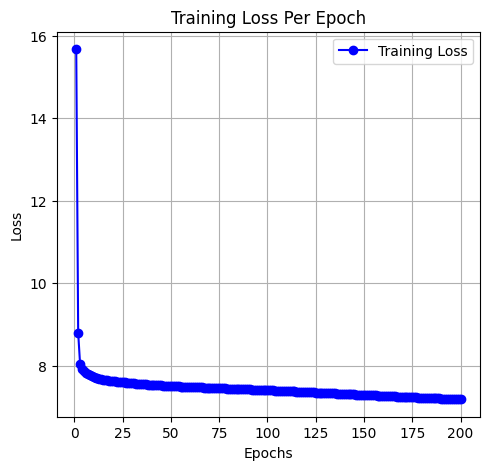

In [212]:

epochs = range(1, len(br_train_loss) + 1)  # Adjust epochs to match the length of train_loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, br_train_loss, label='Training Loss', marker='o', color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Neural Network (LSTM encoder)

In [213]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.feature_dim = hidden_dim * 2 if bidirectional else hidden_dim

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        # Ensure consistent dimensionality regardless of the batch size
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(0)  # Add a batch dimension if it's missing

        if self.lstm.bidirectional:
            # Concatenate the hidden states from both directions
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            # Get the last layer's last direction output
            hidden = hidden[-1]

        return hidden


In [214]:
class Regressor(nn.Module):
    def __init__(self, input_dim):
        super(Regressor, self).__init__()
        self.fc_b1 = nn.Linear(input_dim, 32)
        self.fc_b2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc_b1(x))
        x = F.relu(self.fc_b2(x))
        return x


In [215]:

input_dim = 65  # Input dimensionality
hidden_dim = 64  # Hidden state dimensionality

# Initialize Encoder
encoder = Encoder(input_dim, hidden_dim).to(device)
# Initialize Regressor with encoder's feature_dim
regressor = Regressor(input_dim=encoder.feature_dim).to(device)

# Loss function
loss_func = nn.MSELoss()

# Optimizer
optimizer = optim.SGD(list(encoder.parameters()) + list(regressor.parameters()), lr=0.0001, momentum=0.9, weight_decay=5e-4)

num_epochs = 200



In [216]:
def regression_accuracy(output, target, threshold=0.1):
    """ Calculate "accuracy" for regression within a certain threshold percentage. """
    with torch.no_grad():
        # Calculate the absolute difference
        difference = torch.abs(output - target)
        # Check if the difference is within the threshold * target
        correct = (difference < threshold * torch.abs(target)).float()
        # Calculate accuracy as the mean of correct predictions
        accuracy = 100 * correct.mean()
    return accuracy.item()

# Define threshold percentage for "correctness"
threshold = 0.1

accuracy = regression_accuracy(pred, y0_train, threshold)
print(f'Regression Accuracy (within {threshold*100}%): {accuracy:.2f}%')


Regression Accuracy (within 10.0%): 8.85%


In [217]:
threshold = 0.1  # Define threshold percentage for "correctness"
epoch_accuracies = []
#training loop
train_loss = []
for epoch in range(1, num_epochs + 1):
    encoder.train()
    regressor.train()
    epoch_loss_list = []
    epoch_accuracy_list = []

    for x, y in train_loader_0:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        embedding = encoder(x)
        pred = regressor(embedding)

        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss_list.append(loss.item())

        # Calculate "accuracy" for regression
        accuracy = regression_accuracy(pred, y, threshold)
        epoch_accuracy_list.append(accuracy)

    if len(epoch_loss_list) == 0:
        print("Warning: No data processed this epoch")
        average_loss = 0
        average_accuracy = 0
    else:
        average_loss = sum(epoch_loss_list) / len(epoch_loss_list)
        average_accuracy = sum(epoch_accuracy_list) / len(epoch_accuracy_list)

    train_loss.append(average_loss)
    epoch_accuracies.append(average_accuracy)

    train_loss.append(average_loss)
    epoch_accuracies.append(average_accuracy)

    print(f'Epoch {epoch}: Avg Loss = {average_loss:.4f}, Avg Accuracy = {average_accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Avg Loss = 18.0672, Avg Accuracy = 0.55%
Epoch 2: Avg Loss = 11.9751, Avg Accuracy = 10.56%
Epoch 3: Avg Loss = 8.3941, Avg Accuracy = 9.37%
Epoch 4: Avg Loss = 7.9170, Avg Accuracy = 8.47%
Epoch 5: Avg Loss = 7.8955, Avg Accuracy = 8.76%
Epoch 6: Avg Loss = 7.8958, Avg Accuracy = 8.88%
Epoch 7: Avg Loss = 7.8850, Avg Accuracy = 8.89%
Epoch 8: Avg Loss = 7.9020, Avg Accuracy = 8.65%
Epoch 9: Avg Loss = 7.8914, Avg Accuracy = 8.72%
Epoch 10: Avg Loss = 7.8912, Avg Accuracy = 8.91%
Epoch 11: Avg Loss = 7.8863, Avg Accuracy = 8.75%
Epoch 12: Avg Loss = 7.8899, Avg Accuracy = 8.92%
Epoch 13: Avg Loss = 7.8752, Avg Accuracy = 8.81%
Epoch 14: Avg Loss = 7.8942, Avg Accuracy = 8.59%
Epoch 15: Avg Loss = 7.8937, Avg Accuracy = 8.80%
Epoch 16: Avg Loss = 7.8907, Avg Accuracy = 8.80%
Epoch 17: Avg Loss = 7.8786, Avg Accuracy = 8.65%
Epoch 18: Avg Loss = 7.8832, Avg Accuracy = 8.70%
Epoch 19: Avg Loss = 7.8857, Avg Accuracy = 8.92%
Epoch 20: Avg Loss = 7.8831, Avg Accuracy = 8.76%
Epoch 

In [218]:
batches_per_epoch = len(train_loader_0)
total_batches = num_epochs * batches_per_epoch
epochs = range(1, total_batches + 1)


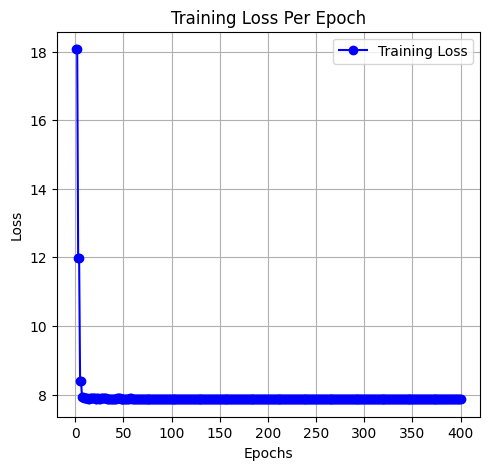

In [219]:

epochs = range(1, len(train_loss) + 1)  # Adjust epochs to match the length of train_loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [220]:

test_loss = []
test_accuracies = []

encoder.eval()
regressor.eval()

with torch.no_grad():
    for x, y in test_loader_0:
        x, y = x.to(device), y.to(device)

        embedding = encoder(x)
        pred = regressor(embedding)

        loss = loss_func(pred, y)
        test_loss.append(loss.item())

        # Calculate "accuracy" for regression
        accuracy = regression_accuracy(pred, y, threshold)
        test_accuracies.append(accuracy)

average_test_loss = sum(test_loss) / len(test_loss)
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)

print(f'Test Results - Average Loss: {average_test_loss:.4f}, Average Accuracy: {average_test_accuracy:.2f}%')


Test Results - Average Loss: 7.7049, Average Accuracy: 8.52%


###NN combinded (linear+LSTM encoder)


In [227]:

class CombinedEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False):
        super(CombinedEncoder, self).__init__()
        # Initialize BaseRegressor and Encoder
        self.base_regressor = BaseRegressor()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers, bidirectional)
        self.final_regressor = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output_base = self.base_regressor(x)
        output_encoder = self.encoder(x)
        summed_output = output_base + output_encoder
        final_output = self.final_regressor(summed_output)
        return final_output


In [228]:
class Regressor(nn.Module):
    def __init__(self, input_dim):
        super(Regressor, self).__init__()
        self.fc_b1 = nn.Linear(input_dim, 32)
        self.fc_b2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc_b1(x))
        x = self.fc_b2(x) #no activation function here, allowing for unbounded output
        return x


In [229]:
def regression_accuracy(output, target, threshold=0.1):
    """ Calculate "accuracy" for regression within a certain threshold percentage. """
    with torch.no_grad():
        # Calculate the absolute difference
        difference = torch.abs(output - target)
        # Check if the difference is within the threshold * target
        correct = (difference < threshold * torch.abs(target)).float()
        # Calculate accuracy as the mean of correct predictions
        accuracy = 100 * correct.mean()
    return accuracy.item()

# threshold percentage for "correctness"
threshold = 0.1

accuracy = regression_accuracy(pred, y0_train, threshold)
print(f'Regression Accuracy (within {threshold*100}%): {accuracy:.2f}%')


Regression Accuracy (within 10.0%): 8.43%


In [230]:
from torch.utils.data import DataLoader, TensorDataset
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CombinedEncoder(input_dim=65, hidden_dim=32, num_layers=1, bidirectional=False)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [231]:

from torch.utils.data import DataLoader, TensorDataset, random_split


features = np.random.randn(10000, 65)
targets = np.random.randn(10000)

features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

dataset = TensorDataset(features_tensor, targets_tensor)


total_samples = features_tensor.size(0)
test_size = int(total_samples * 0.3)
train_size = total_samples - test_size

#  random_split to create training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define the DataLoaders for both training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [232]:
num_epochs = 200
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss

        loss.backward()  # Backward pass and optimize
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += regression_accuracy(outputs, labels, threshold) * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)  # Append the epoch loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')



Epoch 1/200, Loss: 1.0258, Accuracy: 1.03%
Epoch 2/200, Loss: 1.0235, Accuracy: 0.98%
Epoch 3/200, Loss: 1.0210, Accuracy: 0.93%
Epoch 4/200, Loss: 1.0155, Accuracy: 0.96%
Epoch 5/200, Loss: 1.0134, Accuracy: 0.87%
Epoch 6/200, Loss: 1.0142, Accuracy: 0.87%
Epoch 7/200, Loss: 1.0090, Accuracy: 0.80%
Epoch 8/200, Loss: 1.0128, Accuracy: 0.75%
Epoch 9/200, Loss: 1.0101, Accuracy: 0.88%
Epoch 10/200, Loss: 1.0114, Accuracy: 0.77%
Epoch 11/200, Loss: 1.0088, Accuracy: 0.79%
Epoch 12/200, Loss: 1.0097, Accuracy: 0.84%
Epoch 13/200, Loss: 1.0062, Accuracy: 0.77%
Epoch 14/200, Loss: 1.0082, Accuracy: 0.74%
Epoch 15/200, Loss: 1.0005, Accuracy: 0.65%
Epoch 16/200, Loss: 1.0067, Accuracy: 0.69%
Epoch 17/200, Loss: 1.0003, Accuracy: 0.69%
Epoch 18/200, Loss: 1.0038, Accuracy: 0.56%
Epoch 19/200, Loss: 1.0030, Accuracy: 0.65%
Epoch 20/200, Loss: 0.9982, Accuracy: 0.83%
Epoch 21/200, Loss: 1.0004, Accuracy: 0.55%
Epoch 22/200, Loss: 1.0002, Accuracy: 0.74%
Epoch 23/200, Loss: 0.9993, Accuracy: 0.6

In [233]:
model.eval()
test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss


        test_loss += loss.item() * inputs.size(0)
        test_accuracy += regression_accuracy(outputs, labels, threshold) * inputs.size(0)

# Calculate average loss and accuracy over the testing dataset
test_loss /= len(test_loader.dataset)
test_accuracy /= len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 1.0428, Test Accuracy: 0.33%


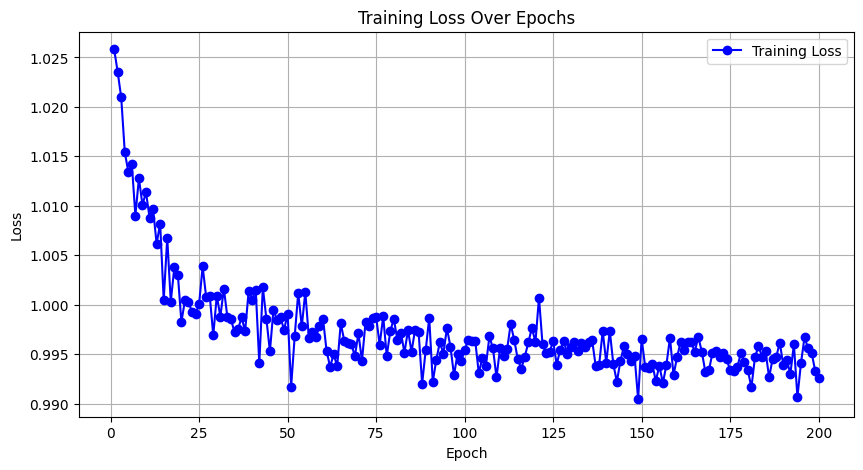

In [234]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
